<a href="https://colab.research.google.com/github/KBVKarthik/Google-Colaboratory-Notebooks/blob/main/Transformer_Encoder_Customizer/Transformer_Encoder_Customizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
     |████████████████████████████████| 211 kB 19.1 MB/s 
     |████████████████████████████████| 679 kB 20.4 MB/s 
     |████████████████████████████████| 636 kB 28.3 MB/s 
     |████████████████████████████████| 99 kB 7.7 MB/s 
     |████████████████████████████████| 1.2 MB 17.0 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 352 kB 36.7 MB/s 
     |████████████████████████████████| 37.1 MB 48 kB/s 


In [2]:
import numpy as np
import tensorflow as tf

from official.modeling import activations
from official.nlp import modeling
from official.nlp.modeling import layers, losses, models, networks

In [3]:
cfg = {
    "vocab_size": 100,
    "hidden_size": 32,
    "num_layers": 3,
    "num_attention_heads": 4,
    "intermediate_size": 64,
    "activation": activations.gelu,
    "dropout_rate": 0.1,
    "attention_dropout_rate": 0.1,
    "max_sequence_length": 16,
    "type_vocab_size": 2,
    "initializer": tf.keras.initializers.TruncatedNormal(stddev=0.02),
}
bert_encoder = modeling.networks.BertEncoder(**cfg)

def build_classifier(bert_encoder):
  return modeling.models.BertClassifier(bert_encoder, num_classes=2)

canonical_classifier_model = build_classifier(bert_encoder)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [4]:
def predict(model):
  batch_size = 3
  np.random.seed(0)
  word_ids = np.random.randint(
      cfg["vocab_size"], size=(batch_size, cfg["max_sequence_length"]))
  mask = np.random.randint(2, size=(batch_size, cfg["max_sequence_length"]))
  type_ids = np.random.randint(
      cfg["type_vocab_size"], size=(batch_size, cfg["max_sequence_length"]))
  print(model([word_ids, mask, type_ids], training=False))

predict(canonical_classifier_model)

tf.Tensor(
[[-0.01655764 -0.09275249]
 [ 0.26150864  0.04595913]
 [ 0.02753941 -0.07236889]], shape=(3, 2), dtype=float32)


In [5]:
default_hidden_cfg = dict(
    num_attention_heads=cfg["num_attention_heads"],
    intermediate_size=cfg["intermediate_size"],
    intermediate_activation=activations.gelu,
    dropout_rate=cfg["dropout_rate"],
    attention_dropout_rate=cfg["attention_dropout_rate"],
    kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
)
default_embedding_cfg = dict(
    vocab_size=cfg["vocab_size"],
    type_vocab_size=cfg["type_vocab_size"],
    hidden_size=cfg["hidden_size"],
    initializer=tf.keras.initializers.TruncatedNormal(0.02),
    dropout_rate=cfg["dropout_rate"],
    max_seq_length=cfg["max_sequence_length"]
)
default_kwargs = dict(
    hidden_cfg=default_hidden_cfg,
    embedding_cfg=default_embedding_cfg,
    num_hidden_instances=cfg["num_layers"],
    pooled_output_dim=cfg["hidden_size"],
    return_all_layer_outputs=True,
    pooler_layer_initializer=tf.keras.initializers.TruncatedNormal(0.02),
)

encoder_scaffold = modeling.networks.EncoderScaffold(**default_kwargs)
classifier_model_from_encoder_scaffold = build_classifier(encoder_scaffold)
classifier_model_from_encoder_scaffold.set_weights(
    canonical_classifier_model.get_weights())
predict(classifier_model_from_encoder_scaffold)

tf.Tensor(
[[-0.01655764 -0.09275249]
 [ 0.26150864  0.04595913]
 [ 0.02753941 -0.07236889]], shape=(3, 2), dtype=float32)


In [6]:
word_ids = tf.keras.layers.Input(
    shape=(cfg['max_sequence_length'],), dtype=tf.int32, name="input_word_ids")
mask = tf.keras.layers.Input(
    shape=(cfg['max_sequence_length'],), dtype=tf.int32, name="input_mask")
embedding_layer = modeling.layers.OnDeviceEmbedding(
    vocab_size=cfg['vocab_size'],
    embedding_width=cfg['hidden_size'],
    initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
    name="word_embeddings")
word_embeddings = embedding_layer(word_ids)
attention_mask = layers.SelfAttentionMask()([word_embeddings, mask])
new_embedding_network = tf.keras.Model([word_ids, mask],
                                       [word_embeddings, attention_mask])

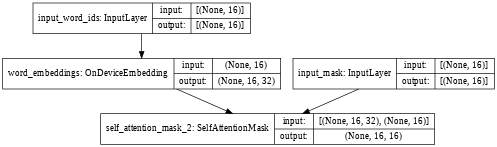

In [7]:
tf.keras.utils.plot_model(new_embedding_network, show_shapes=True, dpi=48)

In [8]:
kwargs = dict(default_kwargs)


kwargs['embedding_cls'] = new_embedding_network
kwargs['embedding_data'] = embedding_layer.embeddings

encoder_with_customized_embedding = modeling.networks.EncoderScaffold(**kwargs)
classifier_model = build_classifier(encoder_with_customized_embedding)

print(classifier_model.inputs)


assert len(classifier_model.inputs) == 2

[<KerasTensor: shape=(None, 16) dtype=int32 (created by layer 'input_word_ids')>, <KerasTensor: shape=(None, 16) dtype=int32 (created by layer 'input_mask')>]


In [9]:
kwargs = dict(default_kwargs)


kwargs['hidden_cls'] = modeling.layers.ReZeroTransformer

encoder_with_rezero_transformer = modeling.networks.EncoderScaffold(**kwargs)
classifier_model = build_classifier(encoder_with_rezero_transformer)

predict(classifier_model)

assert 'rezero_alpha' in ''.join([x.name for x in classifier_model.trainable_weights])

tf.Tensor(
[[-0.20447451  0.8574807 ]
 [ 0.11429253  0.8035786 ]
 [-0.3747787   0.60402703]], shape=(3, 2), dtype=float32)


In [10]:
hidden_cfg = dict(default_hidden_cfg)
hidden_cfg['attention_cls'] = modeling.layers.TalkingHeadsAttention

kwargs = dict(default_kwargs)
kwargs['hidden_cls'] = modeling.layers.TransformerScaffold
kwargs['hidden_cfg'] = hidden_cfg

encoder = modeling.networks.EncoderScaffold(**kwargs)
classifier_model = build_classifier(encoder)

predict(classifier_model)


assert 'pre_softmax_weight' in ''.join([x.name for x in classifier_model.trainable_weights])

tf.Tensor(
[[-0.24934748 -0.13560957]
 [ 0.13873258 -0.283478  ]
 [-0.24195608  0.06037357]], shape=(3, 2), dtype=float32)


In [11]:
hidden_cfg = dict(default_hidden_cfg)
hidden_cfg['feedforward_cls'] = modeling.layers.GatedFeedforward

kwargs = dict(default_kwargs)
kwargs['hidden_cls'] = modeling.layers.TransformerScaffold
kwargs['hidden_cfg'] = hidden_cfg

encoder_with_gated_feedforward = modeling.networks.EncoderScaffold(**kwargs)
classifier_model = build_classifier(encoder_with_gated_feedforward)

predict(classifier_model)


assert 'gate' in ''.join([x.name for x in classifier_model.trainable_weights])

tf.Tensor(
[[-0.06359647  0.13765208]
 [-0.18919158  0.1569277 ]
 [-0.1313      0.19323371]], shape=(3, 2), dtype=float32)


In [12]:
albert_encoder = modeling.networks.AlbertEncoder(**cfg)
classifier_model = build_classifier(albert_encoder)

predict(classifier_model)

tf.Tensor(
[[ 0.01827849  0.01475724]
 [ 0.06613923  0.21178906]
 [-0.05516077  0.14447568]], shape=(3, 2), dtype=float32)


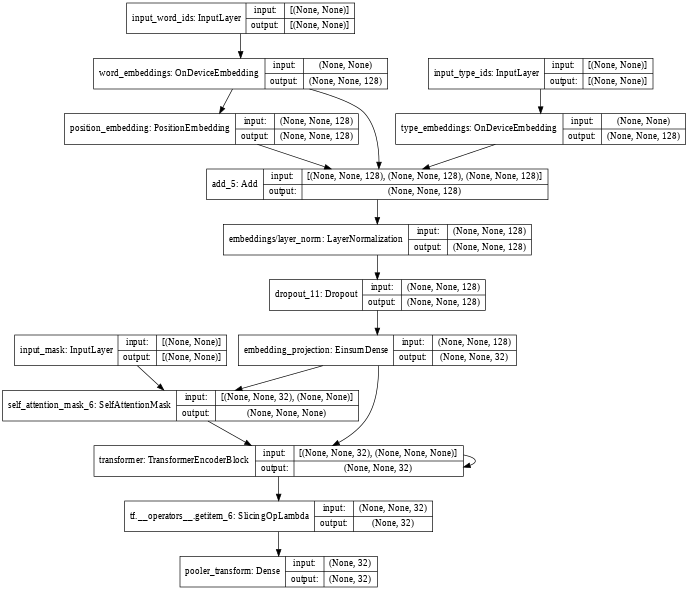

In [13]:
tf.keras.utils.plot_model(albert_encoder, show_shapes=True, dpi=48)